# ATMS 523

## Module 5 Project

Fork this repository, and submit this code as a pull request back to GitHub by the date and time listed in Canvas.

For this assignment, use the dataset called `radar_parameters.csv` provided in the GitHub repository in the folder `homework`.

## Dataset Description

The training data consists of polarimetric radar parameters calculated from a disdrometer (an instrument that measures rain drop sizes, shapes, and rainfall rate) measurements from several years in Huntsville, Alabama. A model called `pytmatrix` is used to calculate polarimetric radar parameters from the droplet observations, which can be used as a way to compare what a remote sensing instrument would see and rainfall.

## Data columns

Features (radar measurements):
`Zh` - radar reflectivity factor (dBZ) - use the formula $dBZ = 10\log_{10}(Z)$
`Zdr` - differential reflectivity
`Ldr` - linear depolarization ratio
`Kdp` - specific differential phase
`Ah` - specific attenuation
`Adp` - differential attenuation
Target :
`R` - rain rate

In [1]:
# j Basic script taken from module 5 templates and modified slightly.
# Additional libraries added as needed.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    accuracy_score,
    precision_score,
    recall_score)
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


# Local helpers
import sys
sys.path.append(str(Path('../src').resolve()))
# from utils import threshold_metrics, roc_pr_curves

# Notebook options
plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['figure.dpi'] = 120

1. Split the data into a 70-30 split for training and testing data.

In [3]:
# Basic script taken from module 5 templates and modified slightly.
# Load and limit real data
USE_SYNTHETIC = False
DATA_PATH = 'radar_parameters.csv'
FEATURES = ['Zh (dBZ)', 'Zdr (dB)', 'Ldr (dB)', 'Kdp (deg km-1)', 'Ah (dBZ/km)', 'Adr (dB/km)']
TARGET = 'R (mm/hr)'

df = pd.read_csv(DATA_PATH)

df = df[FEATURES + [TARGET]].dropna()

# Prepare features and target
X = df[FEATURES].values
y = df[TARGET].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


2. Using the split created in (1), train a multiple linear regression dataset using the training dataset, and validate it using the testing dataset.  Compare the $R^2$ and root mean square errors of model on the training and testing sets to a baseline prediction of rain rate using the formula $Z = 200 R^{1.6}$.

Linear Regression Performance:
Train R^2: 0.988, RMSE: 0.923
Test R^2: 0.989, RMSE: 0.936

Baseline (Z-R) Performance:
Train R^2: -0.784, RMSE: 11.212
Test R^2: -0.739, RMSE: 11.820


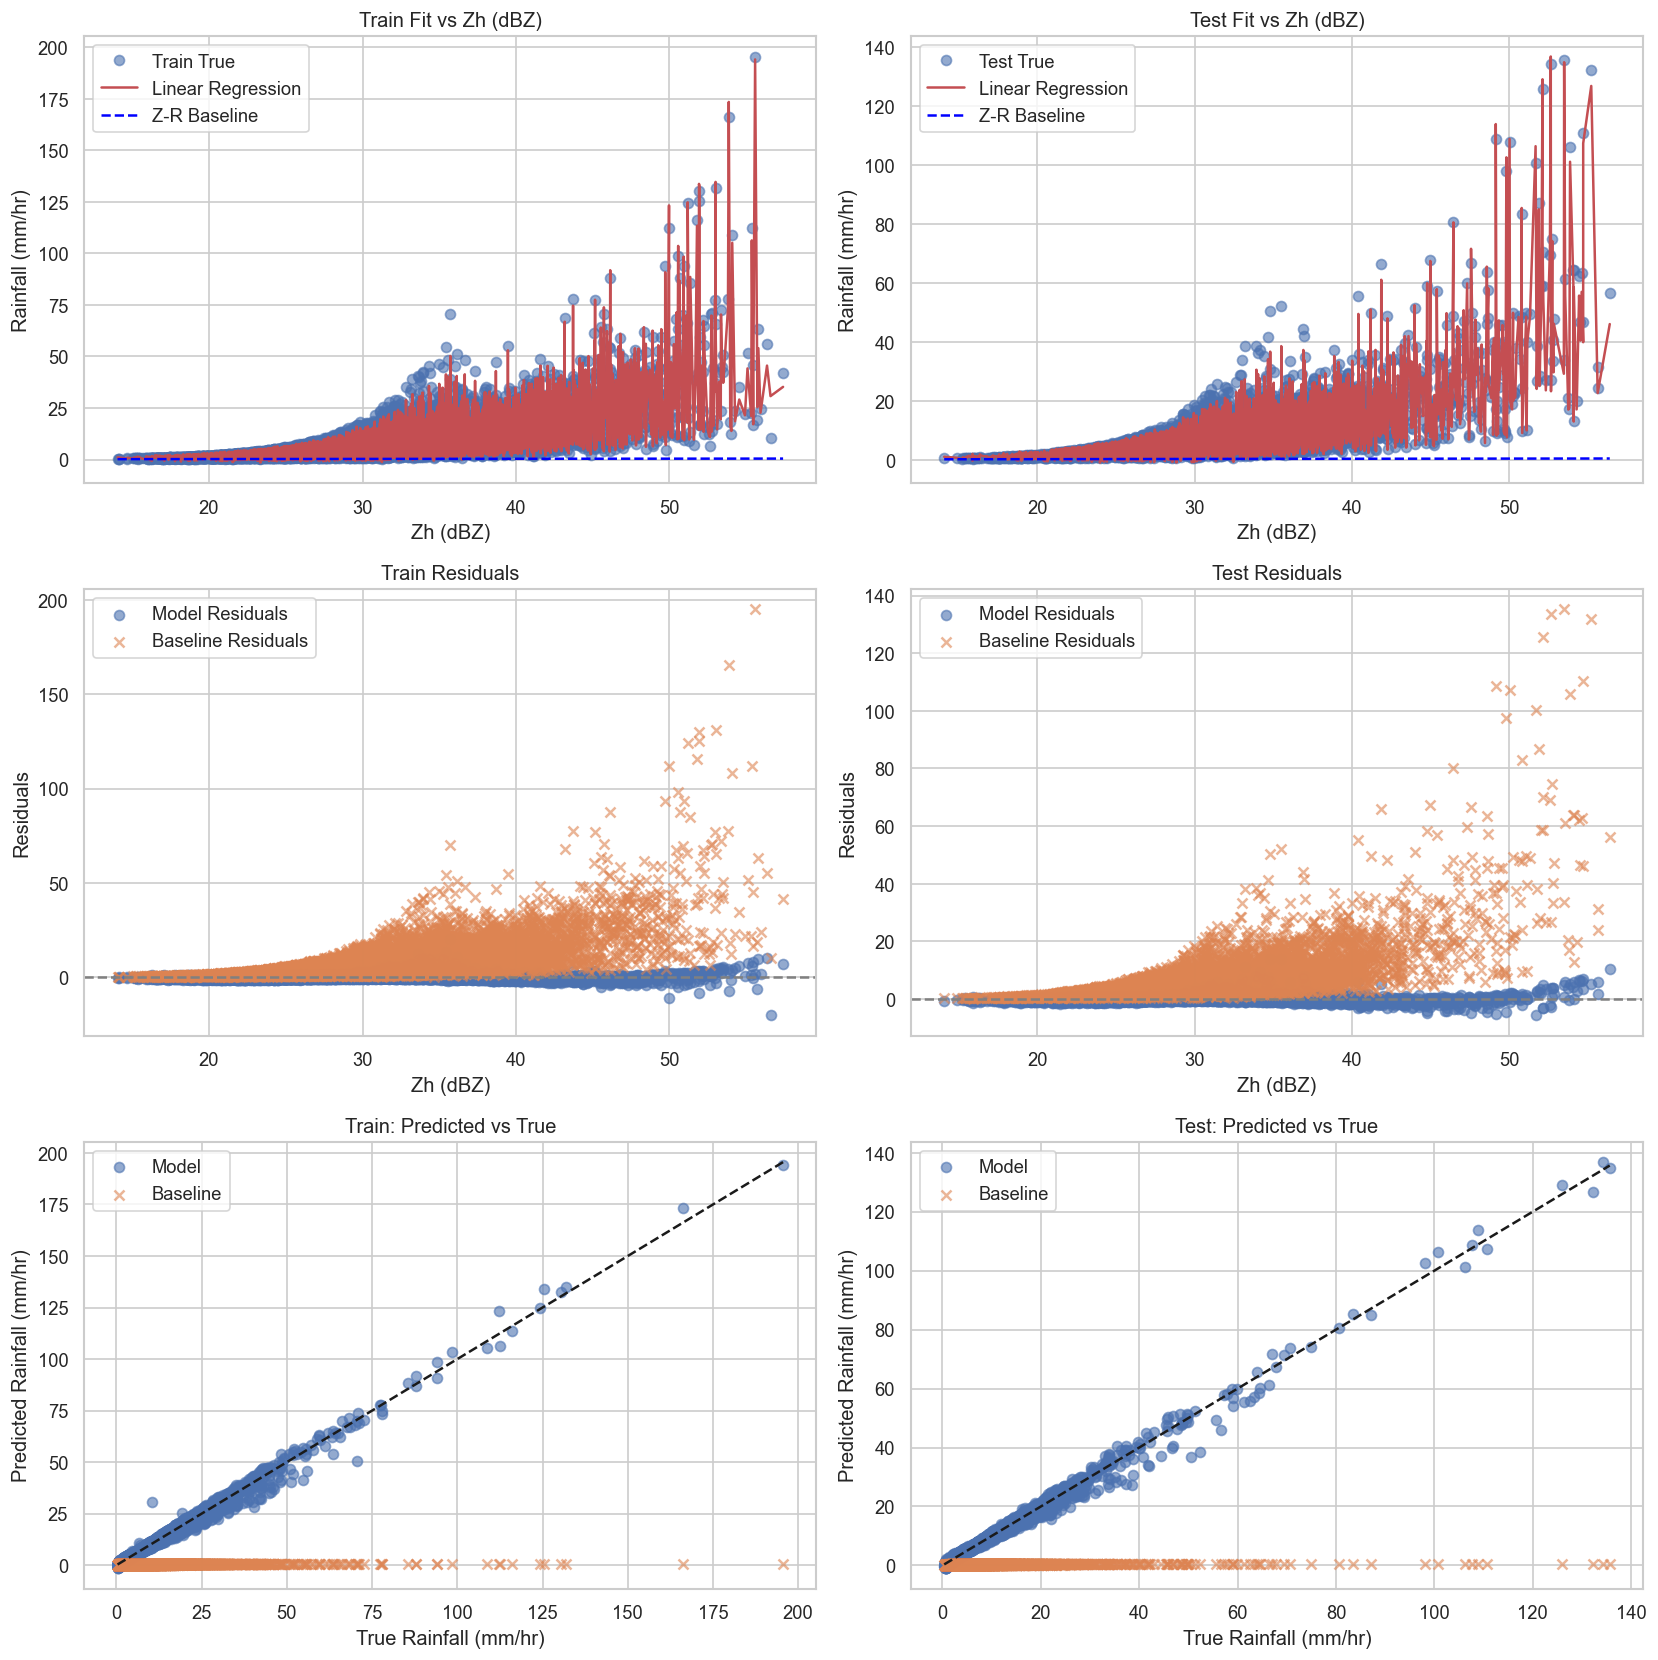

In [ ]:
# Borrowed and adapted from module 5 notebooks.

# Train the model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# R^2 scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# RMSE scores
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Linear Regression Performance:")
print(f"Train R^2: {r2_train:.3f}, RMSE: {rmse_train:.3f}")
print(f"Test R^2: {r2_test:.3f}, RMSE: {rmse_test:.3f}")

# Assuming Z is the first feature (adjust index if needed)
Z_train = X_train[:, 0]
Z_test = X_test[:, 0]

# Baseline rain rate prediction
R_train_baseline = (Z_train / 200) ** (1 / 1.6)
R_test_baseline = (Z_test / 200) ** (1 / 1.6)

# Evaluate baseline
r2_train_base = r2_score(y_train, R_train_baseline)
r2_test_base = r2_score(y_test, R_test_baseline)

rmse_train_base = np.sqrt(mean_squared_error(y_train, R_train_baseline))
rmse_test_base = np.sqrt(mean_squared_error(y_test, R_test_baseline))

print("\nBaseline (Z-R) Performance:")
print(f"Train R^2: {r2_train_base:.3f}, RMSE: {rmse_train_base:.3f}")
print(f"Test R^2: {r2_test_base:.3f}, RMSE: {rmse_test_base:.3f}")


# Plotting function. I wanted to visually see how well this model matched
# up with the observed values. Worked with MS Copilot on this

def plot_model_vs_baseline(
        Z_train,
        y_train,
        y_train_pred,
        R_train_baseline,
        Z_test,
        y_test,
        y_test_pred,
        R_test_baseline,
        feature_name='Zh (dBZ)',
        target_name='Rainfall (mm/hr)'):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(3, 2, figsize=(14, 14))

    sort_idx_train = np.argsort(Z_train)
    sort_idx_test = np.argsort(Z_test)

    # Fit plots
    axes[0, 0].plot(Z_train[sort_idx_train], y_train[sort_idx_train],
                    'o', label='Train True', alpha=0.6)
    axes[0,
         0].plot(Z_train[sort_idx_train],
                 y_train_pred[sort_idx_train],
                 '-',
                 label='Linear Regression',
                 color='r')
    axes[0,
         0].plot(Z_train[sort_idx_train],
                 R_train_baseline[sort_idx_train],
                 '--',
                 label='Z-R Baseline',
                 color='blue')
    axes[0, 0].set_title('Train Fit vs ' + feature_name)
    axes[0, 0].set_xlabel(feature_name)
    axes[0, 0].set_ylabel(target_name)
    axes[0, 0].legend()

    axes[0, 1].plot(Z_test[sort_idx_test], y_test[sort_idx_test],
                    'o', label='Test True', alpha=0.6)
    axes[0, 1].plot(Z_test[sort_idx_test], y_test_pred[sort_idx_test],
                    '-', label='Linear Regression', color='r')
    axes[0,
         1].plot(Z_test[sort_idx_test],
                 R_test_baseline[sort_idx_test],
                 '--',
                 label='Z-R Baseline',
                 color='blue')
    axes[0, 1].set_title('Test Fit vs ' + feature_name)
    axes[0, 1].set_xlabel(feature_name)
    axes[0, 1].set_ylabel(target_name)
    axes[0, 1].legend()

    # Residual plots
    train_resid_model = y_train - y_train_pred
    train_resid_base = y_train - R_train_baseline
    test_resid_model = y_test - y_test_pred
    test_resid_base = y_test - R_test_baseline

    axes[1, 0].scatter(Z_train, train_resid_model,
                       alpha=0.6, label='Model Residuals')
    axes[1, 0].scatter(Z_train, train_resid_base, alpha=0.6,
                       label='Baseline Residuals', marker='x')
    axes[1, 0].axhline(0, color='gray', linestyle='--')
    axes[1, 0].set_title('Train Residuals')
    axes[1, 0].set_xlabel(feature_name)
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].legend()

    axes[1, 1].scatter(Z_test, test_resid_model,
                       alpha=0.6, label='Model Residuals')
    axes[1, 1].scatter(Z_test, test_resid_base, alpha=0.6,
                       label='Baseline Residuals', marker='x')
    axes[1, 1].axhline(0, color='gray', linestyle='--')
    axes[1, 1].set_title('Test Residuals')
    axes[1, 1].set_xlabel(feature_name)
    axes[1, 1].set_ylabel('Residuals')
    axes[1, 1].legend()

    # Predicted vs True
    axes[2, 0].scatter(y_train, y_train_pred, alpha=0.6, label='Model')
    axes[2, 0].scatter(y_train, R_train_baseline, alpha=0.6,
                       label='Baseline', marker='x')
    axes[2, 0].plot([y_train.min(), y_train.max()], [
                    y_train.min(), y_train.max()], 'k--')
    axes[2, 0].set_title('Train: Predicted vs True')
    axes[2, 0].set_xlabel('True ' + target_name)
    axes[2, 0].set_ylabel('Predicted ' + target_name)
    axes[2, 0].legend()

    axes[2, 1].scatter(y_test, y_test_pred, alpha=0.6, label='Model')
    axes[2, 1].scatter(y_test, R_test_baseline, alpha=0.6,
                       label='Baseline', marker='x')
    axes[2, 1].plot([y_test.min(), y_test.max()], [
                    y_test.min(), y_test.max()], 'k--')
    axes[2, 1].set_title('Test: Predicted vs True')
    axes[2, 1].set_xlabel('True ' + target_name)
    axes[2, 1].set_ylabel('Predicted ' + target_name)
    axes[2, 1].legend()

    plt.tight_layout()
    plt.show()


# Call the plot function
plot_model_vs_baseline(
    Z_train, y_train, y_train_pred, R_train_baseline,
    Z_test, y_test, y_test_pred, R_test_baseline,
    feature_name='Zh (dBZ)',
    target_name='Rainfall (mm/hr)'
)

3. Repeat 1 doing a grid search over polynomial orders, using a grid search over orders 0-9, and use cross-validation of 7 folds.  For the best polynomial model in terms of $R^2$, does it outperform the baseline and the linear regression model in terms of $R^2$ and root mean square error?

In [ ]:
# I was running into issues off of dataset loaded for linear regression. Reloading and cleaning again to be safe.
# Load and clean data
DATA_PATH = 'radar_parameters.csv'
FEATURES = [
    'Zh (dBZ)',
    'Zdr (dB)',
    'Ldr (dB)',
    'Kdp (deg km-1)',
    'Ah (dBZ/km)',
    'Adr (dB/km)']
TARGET = 'R (mm/hr)'

df = pd.read_csv(DATA_PATH)
df = df[FEATURES + [TARGET]].dropna()

X = df[FEATURES].values
y = df[TARGET].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Pipeline: scaling + polynomial expansion + linear regression
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('linreg', LinearRegression())
])

# I worked with CoPilot on this code.
# Grid search over polynomial degrees
param_grid = {'poly__degree': list(range(1, 10))}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    return_train_score=True,
    error_score='raise'  # helpful for debugging
)

grid_search.fit(X_train, y_train)

# Identify the best model and degree
best_degree = grid_search.best_params_['poly__degree']
best_model = grid_search.best_estimator_

# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Metrics
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Best Polynomial Degree: {best_degree}")
print(f"Train R²: {r2_train:.6f}, RMSE: {rmse_train:.6f}")
print(f"Test R²: {r2_test:.6f}, RMSE: {rmse_test:.6f}")

Best Polynomial Degree: 2
Train R²: 0.999603, RMSE: 0.167173
Test R²: 0.999581, RMSE: 0.183564


C:\Users\jared\AppData\Local\Temp\ipykernel_15856\846662883.py:59: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\jared\miniconda3\envs\xarray-climate\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


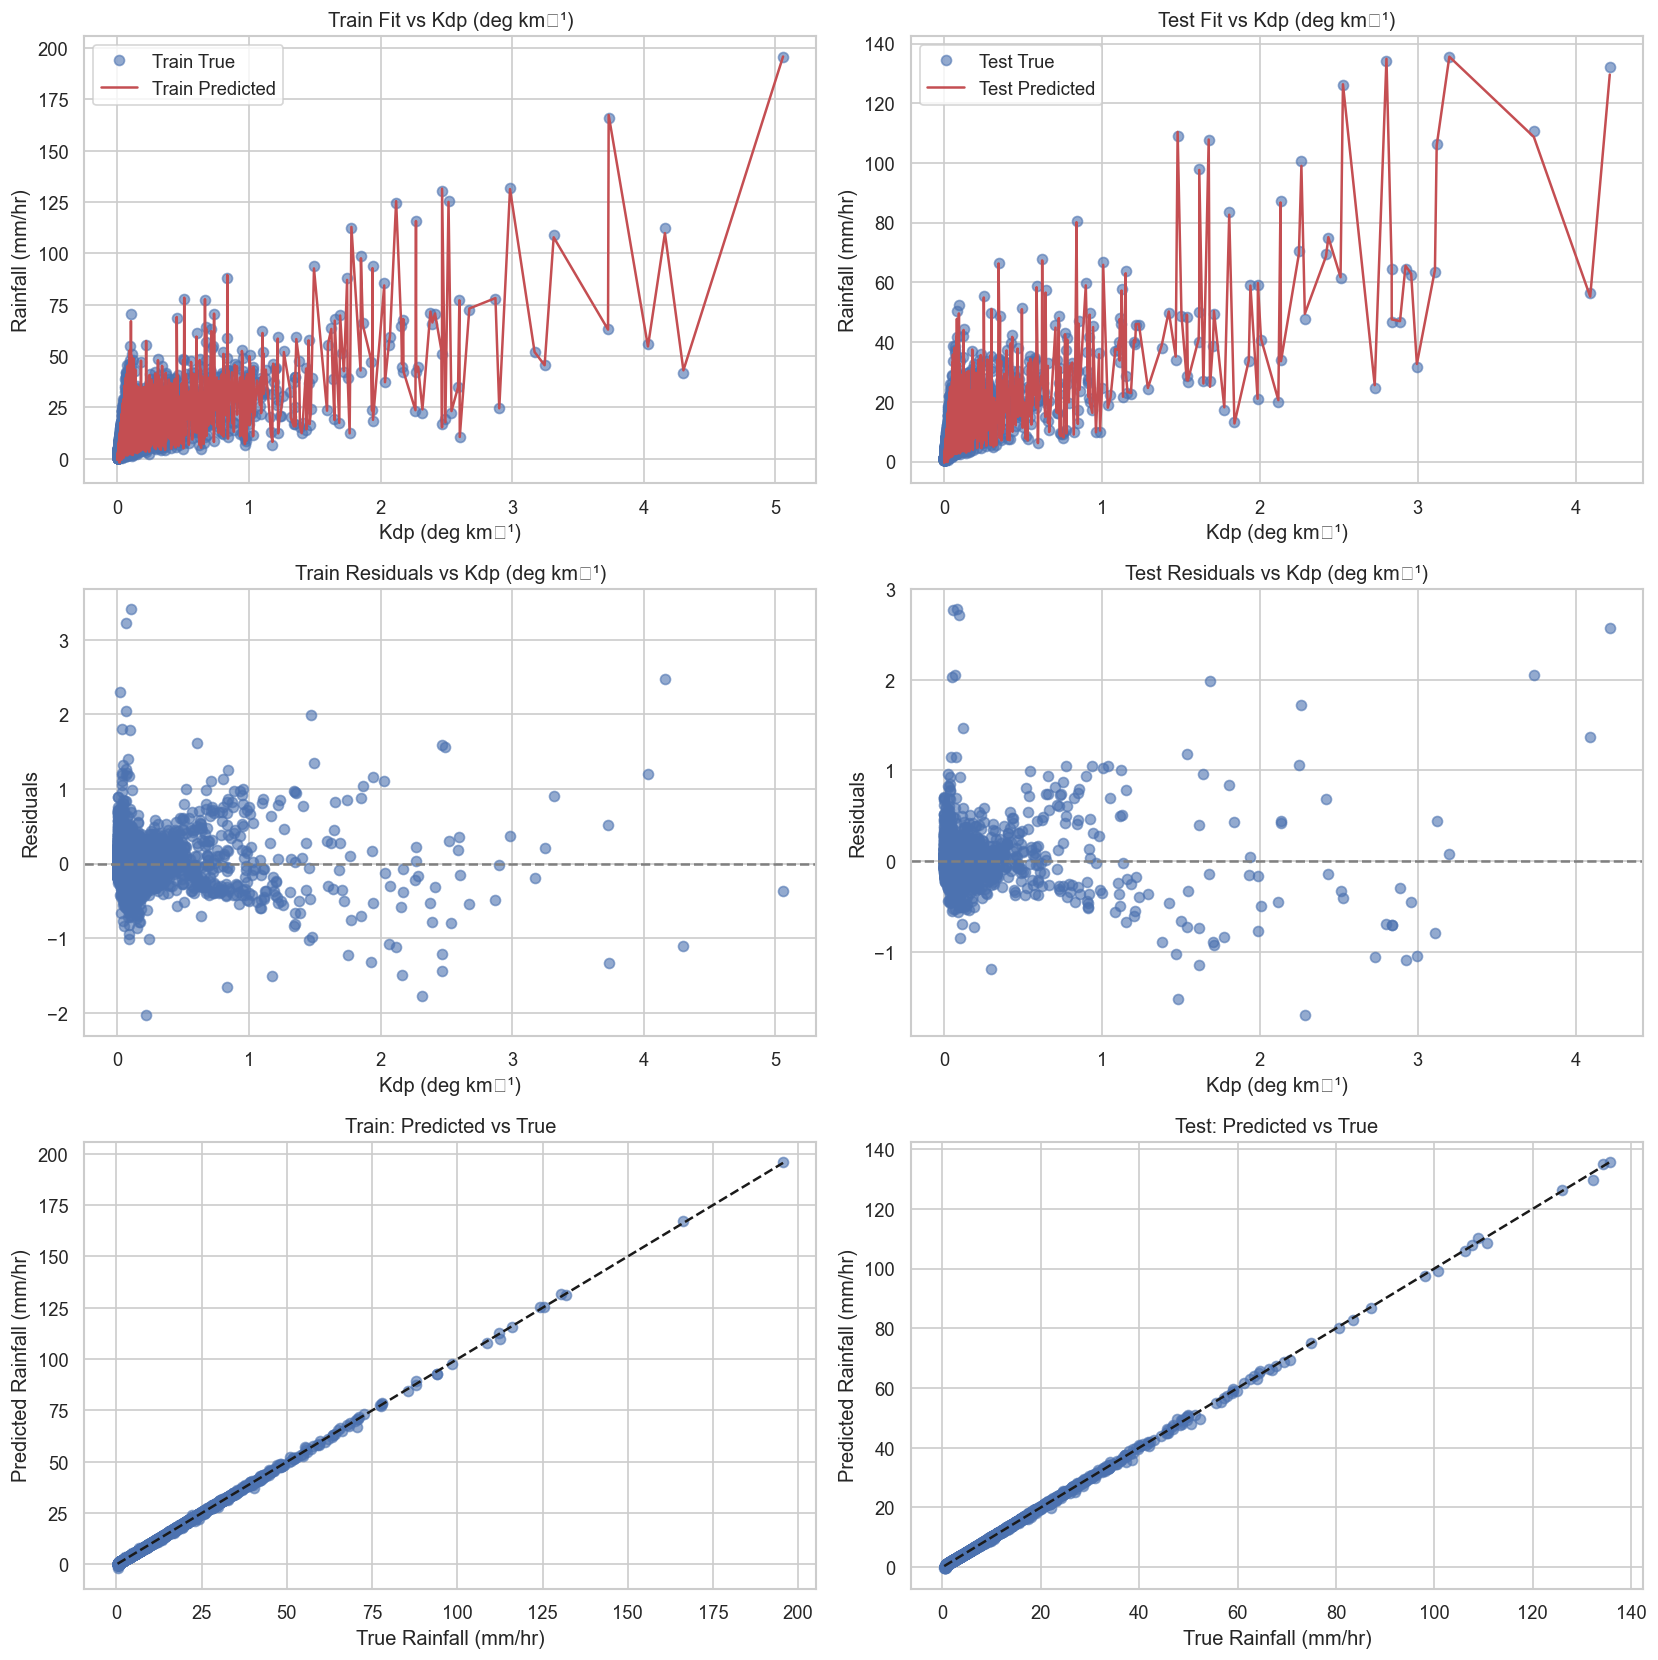

In [ ]:
# Running similar plots as done for linear regression to see visually how things are predicted.
# Based again on MS CoPilot assistance
def plot_fit_and_residuals(X_train, y_train, y_train_pred,
                           X_test, y_test, y_test_pred,
                           feature_index=3,  # Default to Kdp
                           feature_name='Kdp (deg km⁻¹)',
                           target_name='Rainfall (mm/hr)'):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(3, 2, figsize=(14, 14))

    # Sort for smooth plotting
    sort_idx_train = np.argsort(X_train[:, feature_index])
    sort_idx_test = np.argsort(X_test[:, feature_index])

    # Fit plots
    axes[0, 0].plot(X_train[sort_idx_train, feature_index],
                    y_train[sort_idx_train], 'o', label='Train True', alpha=0.6)
    axes[0,
         0].plot(X_train[sort_idx_train,
                         feature_index],
                 y_train_pred[sort_idx_train],
                 '-',
                 label='Train Predicted',
                 color='r')
    axes[0, 0].set_title('Train Fit vs ' + feature_name)
    axes[0, 0].set_xlabel(feature_name)
    axes[0, 0].set_ylabel(target_name)
    axes[0, 0].legend()

    axes[0, 1].plot(X_test[sort_idx_test, feature_index],
                    y_test[sort_idx_test], 'o', label='Test True', alpha=0.6)
    axes[0,
         1].plot(X_test[sort_idx_test,
                        feature_index],
                 y_test_pred[sort_idx_test],
                 '-',
                 label='Test Predicted',
                 color='r')
    axes[0, 1].set_title('Test Fit vs ' + feature_name)
    axes[0, 1].set_xlabel(feature_name)
    axes[0, 1].set_ylabel(target_name)
    axes[0, 1].legend()

    # Residual plots
    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred

    axes[1, 0].scatter(X_train[:, feature_index], train_residuals, alpha=0.6)
    axes[1, 0].axhline(0, color='gray', linestyle='--')
    axes[1, 0].set_title('Train Residuals vs ' + feature_name)
    axes[1, 0].set_xlabel(feature_name)
    axes[1, 0].set_ylabel('Residuals')

    axes[1, 1].scatter(X_test[:, feature_index], test_residuals, alpha=0.6)
    axes[1, 1].axhline(0, color='gray', linestyle='--')
    axes[1, 1].set_title('Test Residuals vs ' + feature_name)
    axes[1, 1].set_xlabel(feature_name)
    axes[1, 1].set_ylabel('Residuals')

    # Predicted vs True
    axes[2, 0].scatter(y_train, y_train_pred, alpha=0.6)
    axes[2, 0].plot([y_train.min(), y_train.max()], [
                    y_train.min(), y_train.max()], 'k--')
    axes[2, 0].set_title('Train: Predicted vs True')
    axes[2, 0].set_xlabel('True ' + target_name)
    axes[2, 0].set_ylabel('Predicted ' + target_name)

    axes[2, 1].scatter(y_test, y_test_pred, alpha=0.6)
    axes[2, 1].plot([y_test.min(), y_test.max()], [
                    y_test.min(), y_test.max()], 'k--')
    axes[2, 1].set_title('Test: Predicted vs True')
    axes[2, 1].set_xlabel('True ' + target_name)
    axes[2, 1].set_ylabel('Predicted ' + target_name)

    plt.tight_layout()
    plt.show()


# Call the function
plot_fit_and_residuals(
    X_train, y_train, y_train_pred,
    X_test, y_test, y_test_pred,
    feature_index=3,  # Kdp is column 3
    feature_name='Kdp (deg km⁻¹)',
    target_name='Rainfall (mm/hr)'
)

4. Repeat 1 with a Random Forest Regressor, and perform a grid_search on the following parameters:
   
   ```python
   param_grid = {
    "bootstrap": [True, False],
    "max_depth": [10, 100],
    "max_features": ["sqrt", 1.0],  
    "min_samples_leaf": [1, 4],
    "min_samples_split": [2, 10],
    "n_estimators": [200, 1000]}
   ```

In [ ]:
# Define the parameter grid (per MS Copilot)
param_grid = {
    "bootstrap": [True, False],
    "max_depth": [10, 100],
    "max_features": ["sqrt", 1.0],
    "min_samples_leaf": [1, 4],
    "min_samples_split": [2, 10],
    "n_estimators": [200, 1000]
}

# Initialize the model
rf = RandomForestRegressor(random_state=0)

# Set up GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=7,
    scoring='r2',
    n_jobs=-1,       # Use all cores for speed
    verbose=1        # Optional: shows progress
)

# Fit the grid search
grid_search_rf.fit(X_train, y_train)

Fitting 7 folds for each of 64 candidates, totalling 448 fits


,estimator,RandomForestR...andom_state=0)
,param_grid,"{'bootstrap': [True, False], 'max_depth': [10, 100], 'max_features': ['sqrt', 1.0], 'min_samples_leaf': [1, 4], ...}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,7
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,1000


In [ ]:
# Identify best model and parameters.
best_rf = grid_search_rf.best_estimator_
best_params = grid_search_rf.best_params_

# Predictions
y_train_rf = best_rf.predict(X_train)
y_test_rf = best_rf.predict(X_test)

# Metrics
r2_train_rf = r2_score(y_train, y_train_rf)
r2_test_rf = r2_score(y_test, y_test_rf)

rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_rf))
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_rf))

print("Best Random Forest Parameters:")
print(best_params)
print(f"Train R^2: {r2_train_rf:.3f}, RMSE: {rmse_train_rf:.3f}")
print(f"Test R^2: {r2_test_rf:.3f}, RMSE: {rmse_test_rf:.3f}")

Best Random Forest Parameters:
{'bootstrap': True, 'max_depth': 100, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Train R^2: 0.997, RMSE: 0.428
Test R^2: 0.987, RMSE: 1.003


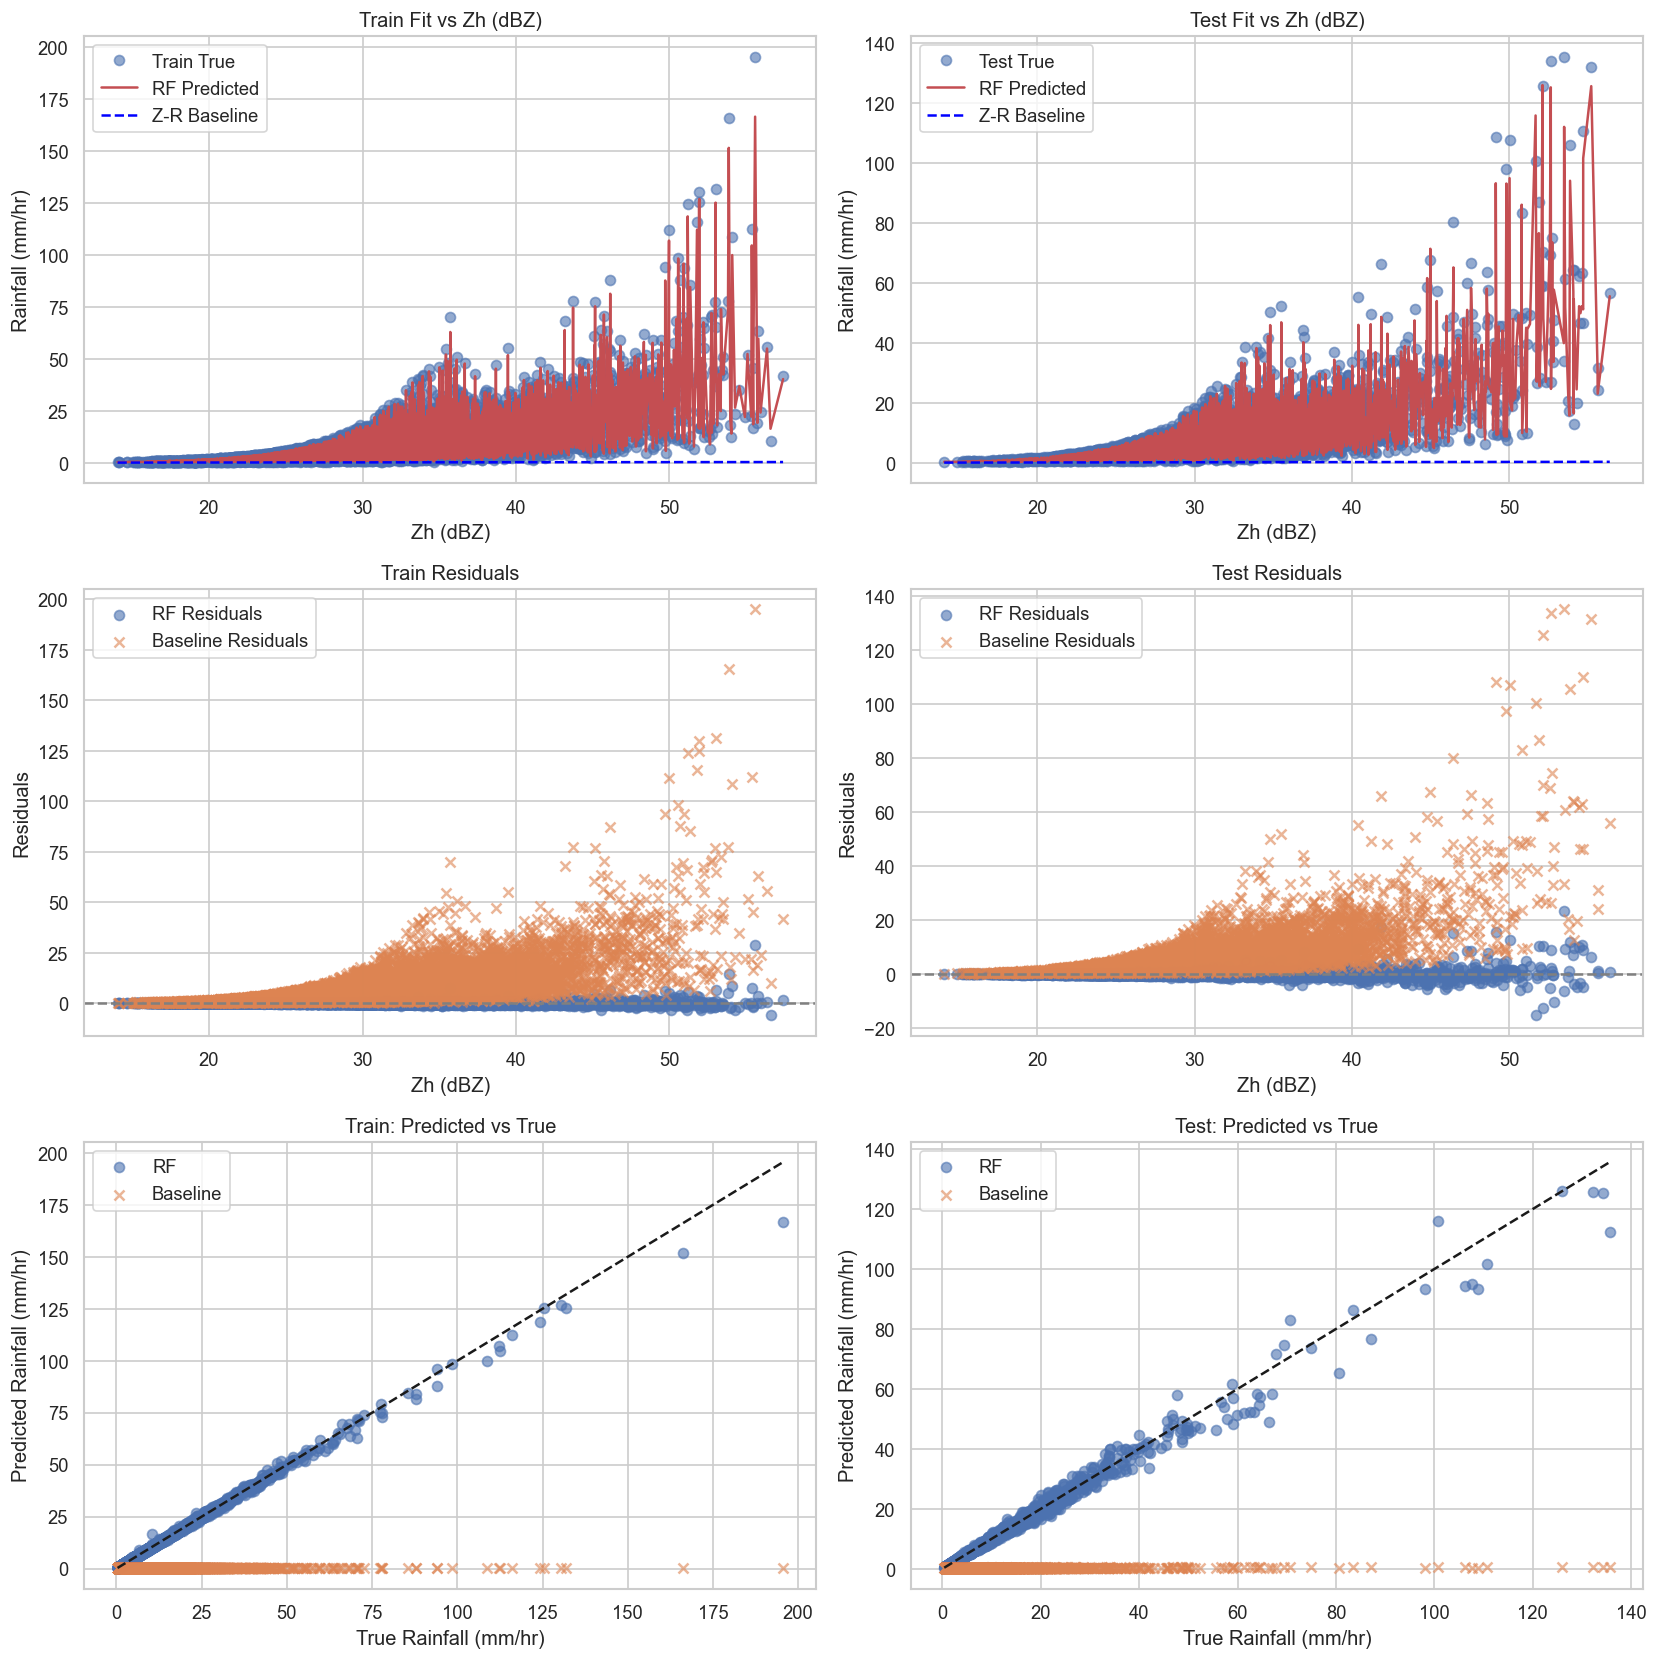

In [ ]:
# Plot results similar to what was done for polynomial and linear regressions.
# Based on Copilot code.
# Note need to improve plots
def plot_rf_vs_baseline(X_train, y_train, y_train_rf, y_train_baseline,
                        X_test, y_test, y_test_rf, y_test_baseline,
                        feature_index=0,  # Default to Zh
                        feature_name='Zh (dBZ)',
                        target_name='Rainfall (mm/hr)'):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(3, 2, figsize=(14, 14))

    sort_idx_train = np.argsort(X_train[:, feature_index])
    sort_idx_test = np.argsort(X_test[:, feature_index])

    # Fit plots
    axes[0, 0].plot(X_train[sort_idx_train, feature_index],
                    y_train[sort_idx_train], 'o', label='Train True', alpha=0.6)
    axes[0,
         0].plot(X_train[sort_idx_train,
                         feature_index],
                 y_train_rf[sort_idx_train],
                 '-',
                 label='RF Predicted',
                 color='r')
    axes[0,
         0].plot(X_train[sort_idx_train,
                         feature_index],
                 y_train_baseline[sort_idx_train],
                 '--',
                 label='Z-R Baseline',
                 color='blue')
    axes[0, 0].set_title('Train Fit vs ' + feature_name)
    axes[0, 0].set_xlabel(feature_name)
    axes[0, 0].set_ylabel(target_name)
    axes[0, 0].legend()

    axes[0, 1].plot(X_test[sort_idx_test, feature_index],
                    y_test[sort_idx_test], 'o', label='Test True', alpha=0.6)
    axes[0, 1].plot(X_test[sort_idx_test, feature_index],
                    y_test_rf[sort_idx_test], '-', label='RF Predicted', color='r')
    axes[0,
         1].plot(X_test[sort_idx_test,
                        feature_index],
                 y_test_baseline[sort_idx_test],
                 '--',
                 label='Z-R Baseline',
                 color='blue')
    axes[0, 1].set_title('Test Fit vs ' + feature_name)
    axes[0, 1].set_xlabel(feature_name)
    axes[0, 1].set_ylabel(target_name)
    axes[0, 1].legend()

    # Residual plots
    train_resid_rf = y_train - y_train_rf
    train_resid_base = y_train - y_train_baseline
    test_resid_rf = y_test - y_test_rf
    test_resid_base = y_test - y_test_baseline

    axes[1, 0].scatter(X_train[:, feature_index],
                       train_resid_rf, alpha=0.6, label='RF Residuals')
    axes[1, 0].scatter(X_train[:, feature_index], train_resid_base,
                       alpha=0.6, label='Baseline Residuals', marker='x')
    axes[1, 0].axhline(0, color='gray', linestyle='--')
    axes[1, 0].set_title('Train Residuals')
    axes[1, 0].set_xlabel(feature_name)
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].legend()

    axes[1, 1].scatter(X_test[:, feature_index], test_resid_rf,
                       alpha=0.6, label='RF Residuals')
    axes[1, 1].scatter(X_test[:, feature_index], test_resid_base,
                       alpha=0.6, label='Baseline Residuals', marker='x')
    axes[1, 1].axhline(0, color='gray', linestyle='--')
    axes[1, 1].set_title('Test Residuals')
    axes[1, 1].set_xlabel(feature_name)
    axes[1, 1].set_ylabel('Residuals')
    axes[1, 1].legend()

    # Predicted vs True
    axes[2, 0].scatter(y_train, y_train_rf, alpha=0.6, label='RF')
    axes[2, 0].scatter(y_train, y_train_baseline, alpha=0.6,
                       label='Baseline', marker='x')
    axes[2, 0].plot([y_train.min(), y_train.max()], [
                    y_train.min(), y_train.max()], 'k--')
    axes[2, 0].set_title('Train: Predicted vs True')
    axes[2, 0].set_xlabel('True ' + target_name)
    axes[2, 0].set_ylabel('Predicted ' + target_name)
    axes[2, 0].legend()

    axes[2, 1].scatter(y_test, y_test_rf, alpha=0.6, label='RF')
    axes[2, 1].scatter(y_test, y_test_baseline, alpha=0.6,
                       label='Baseline', marker='x')
    axes[2, 1].plot([y_test.min(), y_test.max()], [
                    y_test.min(), y_test.max()], 'k--')
    axes[2, 1].set_title('Test: Predicted vs True')
    axes[2, 1].set_xlabel('True ' + target_name)
    axes[2, 1].set_ylabel('Predicted ' + target_name)
    axes[2, 1].legend()

    plt.tight_layout()
    plt.show()


# Baseline Z-R prediction using Zh (column 0)
Z_train = X_train[:, 0]
Z_test = X_test[:, 0]
y_train_baseline = (Z_train / 200) ** (1 / 1.6)
y_test_baseline = (Z_test / 200) ** (1 / 1.6)

# Call the plot
plot_rf_vs_baseline(
    X_train, y_train, y_train_rf, y_train_baseline,
    X_test, y_test, y_test_rf, y_test_baseline,
    feature_index=0,  # Zh
    feature_name='Zh (dBZ)',
    target_name='Rainfall (mm/hr)'
)

  Can you beat the baseline, or the linear regression, or best polynomial model with the best optimized Random Forest Regressor in terms of $R^2$ and root mean square error?

Based on the results from the models, it looks like the best polynomial model is the strongest.
- It is very high with a Test R^2 value of over 0.9996 and an RMSE of 0.1836

- One concern I have is if these factors over fit the results. A R^2 of 0.9996 is extremely high. I tried different parameters, but did continually get results that high. 

Linear regression also quite strong.
- It has a Test R^2 of 0.989 and an RMSE of 0.936.
- Note at this step (since it was the first), I plotted baseline residuals. It had a very low R^2 and very high residuals.
    - That combined with the strong performance of the model indicated to me that the linear model is solid at predicting rainfall rate compared to a baseline of random guessing.

Lastly, according to my testing, is the Random Forest Regressor
- It has a Test R^2 of 0.987 and an RMSE: 1.003. So it was very close to the linear regression model.

My intepretation of why this is as follows (based off of an extremely limited understanding of weather radar technology):
- Simply predicting rainfall off of Zh (radar reflectivity factor (dBZ)) is a very strong predictor of rainfall rate.
- Adding in an analysis covering the below items only strengthens the predictive model
    `Zdr` - differential reflectivity
    `Ldr` - linear depolarization ratio
    `Kdp` - specific differential phase
    `Ah` - specific attenuation
    `Adp` - differential attenuation
    
I am left believing that the various components of radar technology work together to provde a very strong correlation with rainfall rate, with the caveat that overfiting could be a possibility given that I am new to this type of analysis.
